In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
#matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import pdb
import h5py
import importlib
import pickle

# Add root folder to sys path
sys.path.append("../")

# %pylab inline
# inline doesn't give interactive plots
%matplotlib inline 
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

sns.set()

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import own modules
# Need to use importlib since module starts with a numerical value.

from load_expert_traj import Expert, ExpertHDF5

plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots

In [2]:
def plot_data_n_colors_policy(data, grid_size, policy,
                              bounds=[-100, -0.5, 0.5, 1000],
                              color_map=['black', 'grey', 'red'],
                              save_path=''):
    
    cmap = matplotlib.colors.ListedColormap(color_map)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(data, cmap=cmap, norm=norm, extent=[0, grid_size, 0, grid_size],
              )

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.grid(True)
    ax.autoscale(enable=False)

    for a, m in [(0, '>'), (1, 'v'), (2, '<'), (3, '^')]:
        if len(np.where(policy == a)) > 0:
            x, y = np.where(policy == a)
            # Why this weird math?
            # Original grid map has origin at top left (usual for images).
            # imshow (above) has a property `extent` which allows us to define the origin
            # location when rendering. But ax.scatter (below) doesn't have such an API,
            # it rather defines origin at  bottom left corner hence to convert to top left
            # we do the below math.
            ax.scatter(x=y + 0.5, y=grid_size - 1 - x + 0.5, c='r',
                       s=120, marker=m, edgecolors='none')
    if len(save_path) > 0:
        fig.savefig(save_path)
        
    fig.show()
    
def plot_trajectory(traj_data, grid_size,
                    pred_traj_data=None,
                    bounds=[-100, -.5, .5, 100],
                    color_map=['black', 'grey', 'red'],
                    save_path='', figsize=(6,6)):
    cmap = matplotlib.colors.ListedColormap(color_map)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(np.ones((grid_size, grid_size)), 
              cmap=cmap,
              norm=norm,
              extent=[0, grid_size, 0, grid_size],
              interpolation='none', aspect='equal'
              )

    #ax.get_xaxis().set_ticklabels([])
    #ax.get_yaxis().set_ticklabels([])
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.grid(True)    

    for i in range(traj_data.shape[0]):
        x, y = traj_data[i, 0], traj_data[i, 1]
        ax.scatter(x=y + 0.5, y=grid_size - 1 - x + 0.5, c='r',
                       s=120, marker='.', edgecolors='none')
        
        if pred_traj_data is not None:
            pred_x, pred_y = pred_traj_data[i, 0], pred_traj_data[i, 1]
            ax.scatter(x=y + 0.75, y=grid_size - 1 - x + 0.75, c='g',
                       s=120, marker='.', edgecolors='none')

    if len(save_path) > 0:
        fig.savefig(save_path)
    
    fig.tight_layout()
    #fig.show()


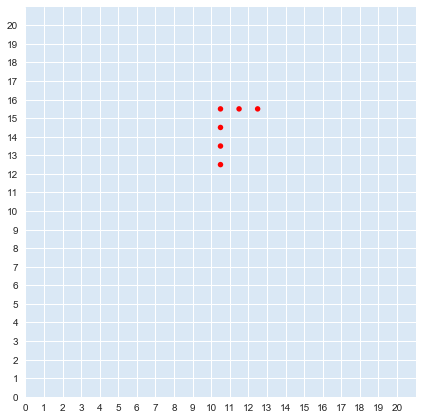

In [3]:
def plot_expert_trajectories_from_h5(expert_h5_path, num_traj_to_plot=10):
    expert = ExpertHDF5(expert_h5_path, 2)
    # Push data into memory
    expert.push()
    
    expert_data = expert.sample(num_traj_to_plot)
    
    for i in range(num_traj_to_plot):
        ep_states = expert_data.state[i]
        ep_actions = expert_data.action[i]
        # get (x, y) states for trajectories
        ep_positions = ep_states[:, :2]
        # Plot trajectory
        plot_trajectory(ep_positions,
                        21,
                        color_map=sns.color_palette("Blues_r"),
                        figsize=(6, 6))


plot_expert_trajectories_from_h5('../h5_trajs/L_trajs',
                                 num_traj_to_plot=1,
                                 )

<class 'dict'>


/Users/mohit/bin/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


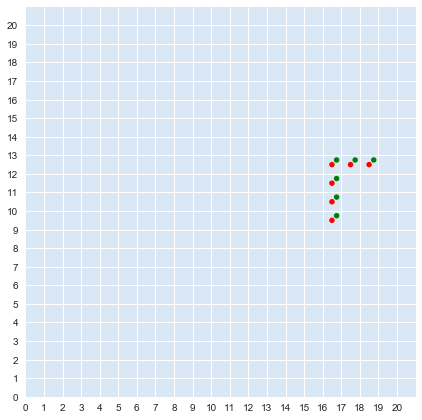

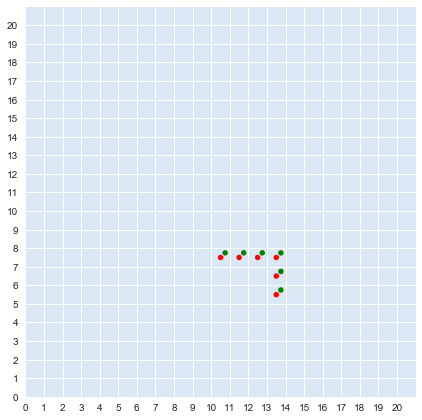

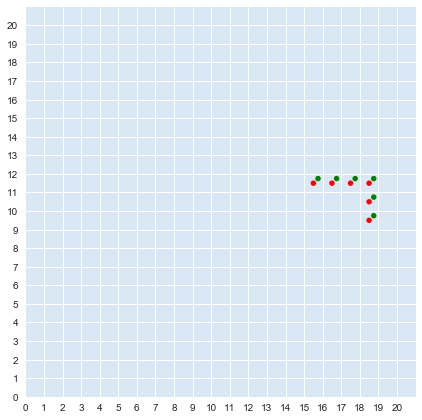

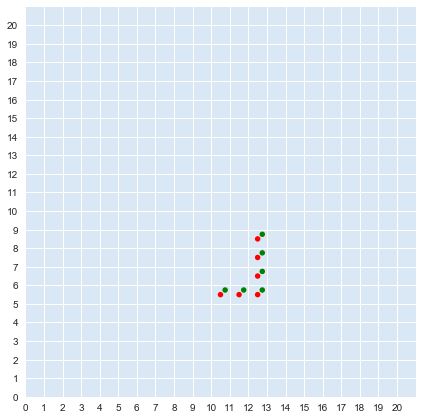

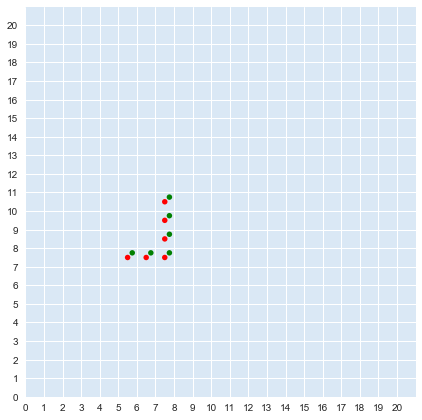

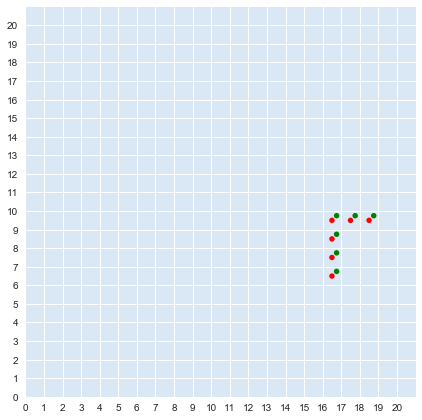

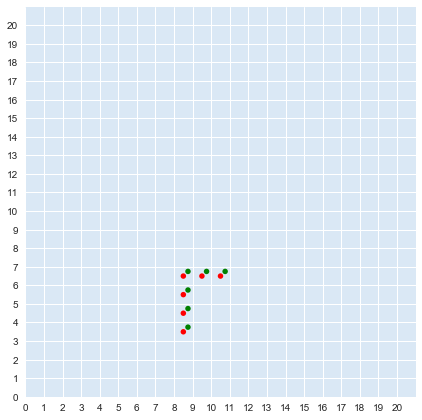

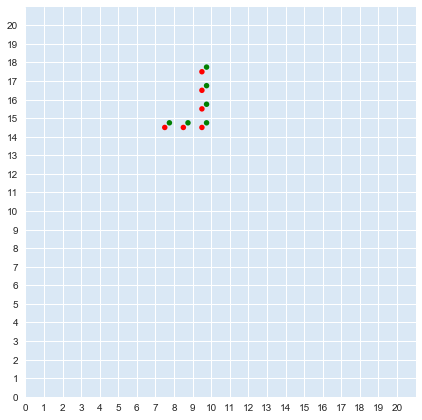

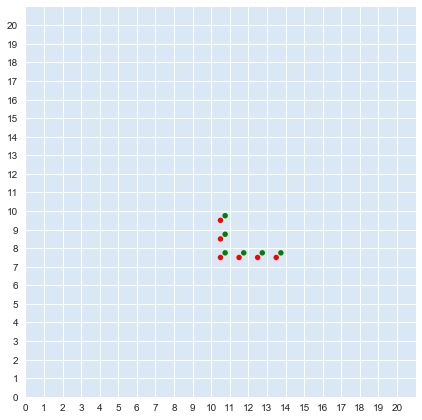

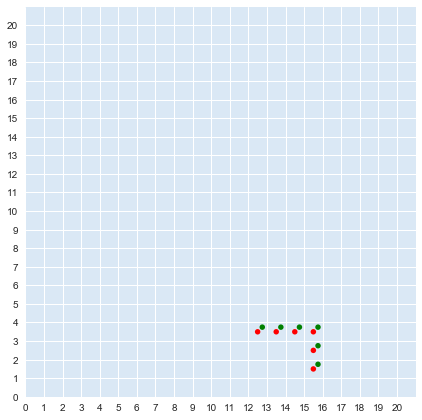

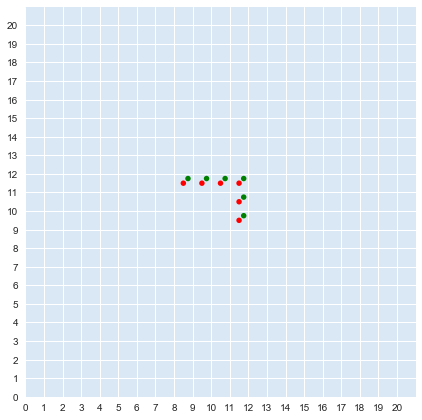

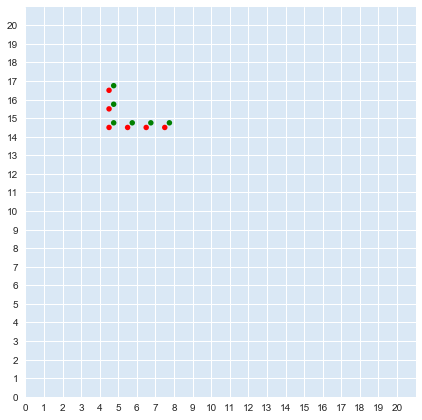

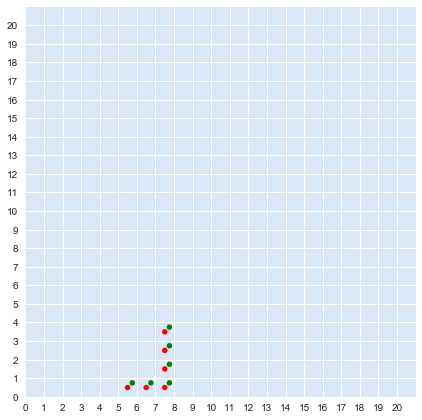

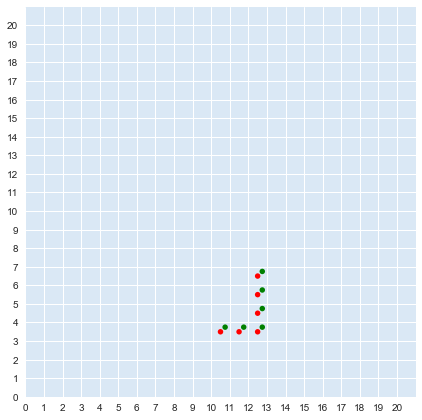

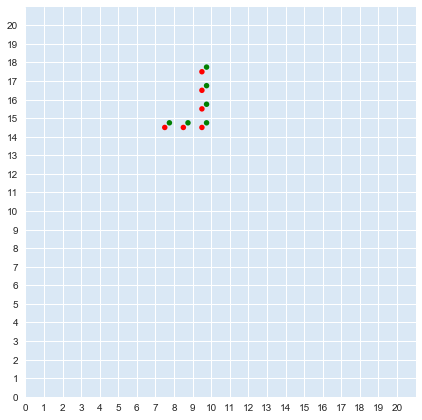

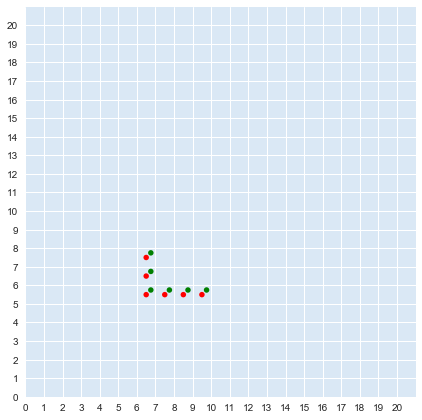

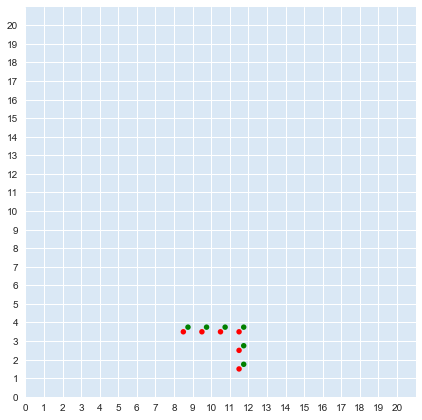

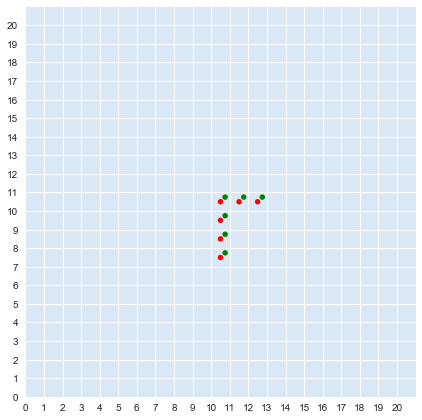

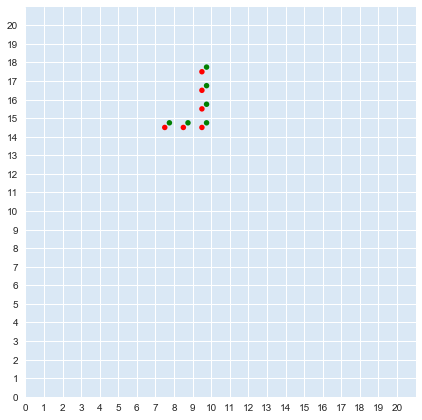

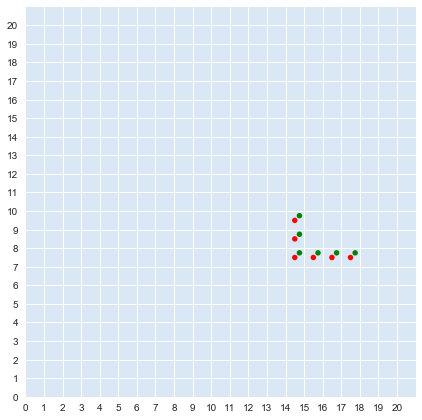

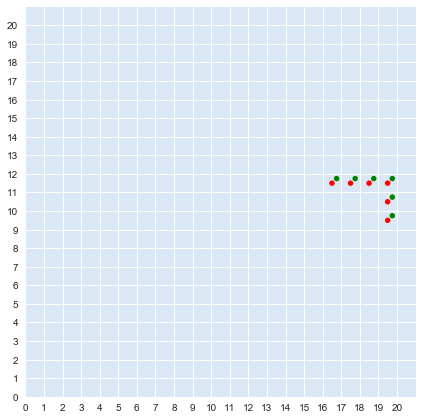

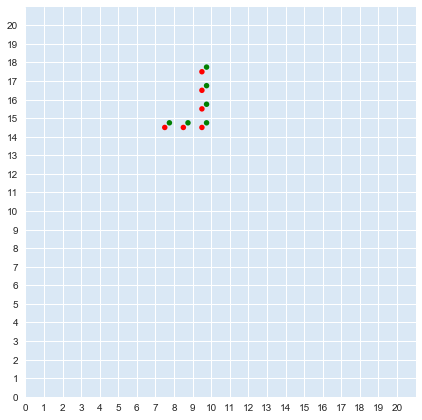

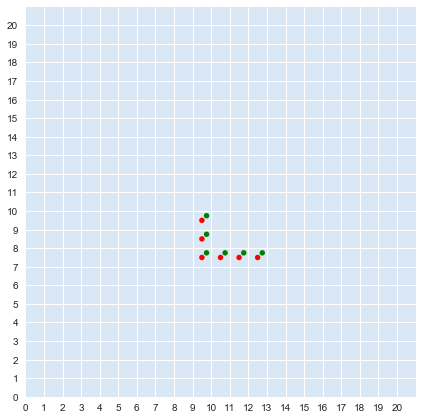

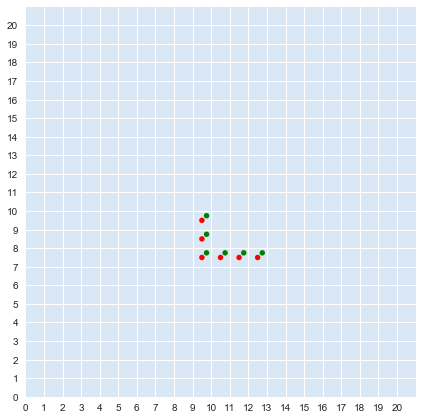

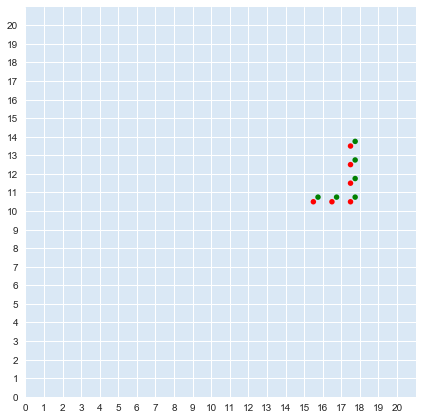

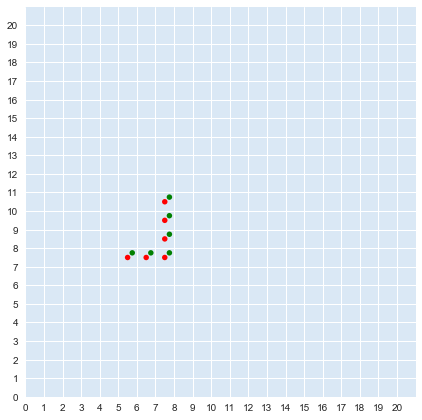

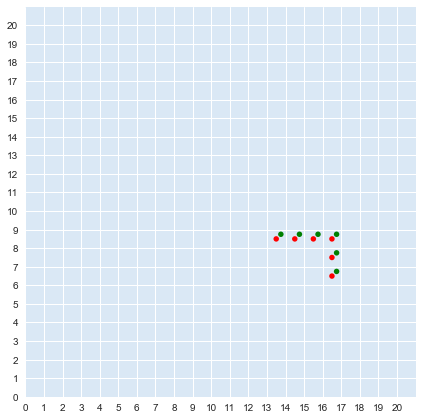

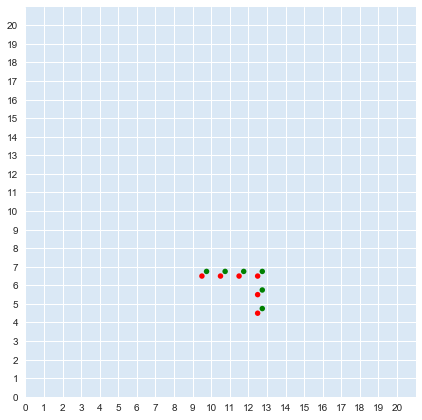

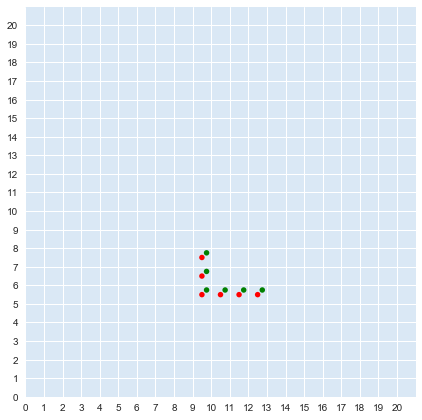

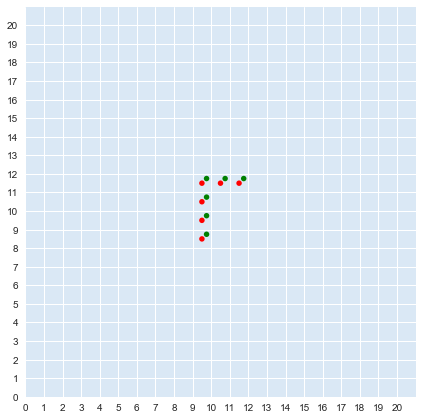

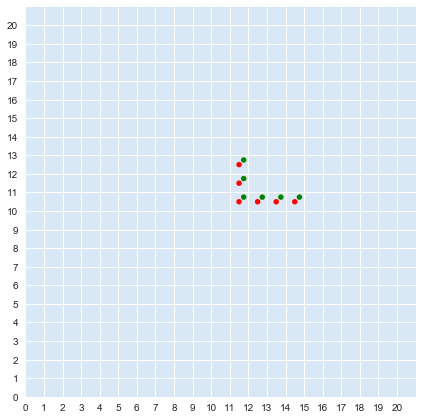

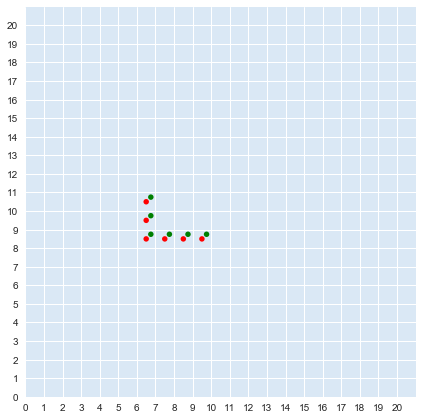

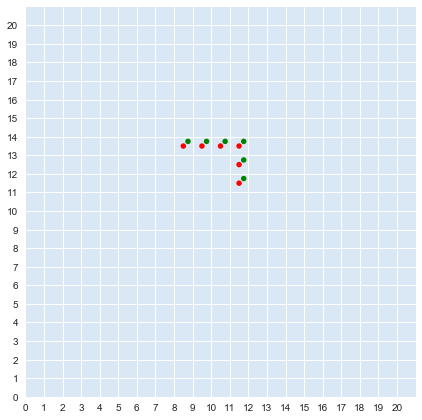

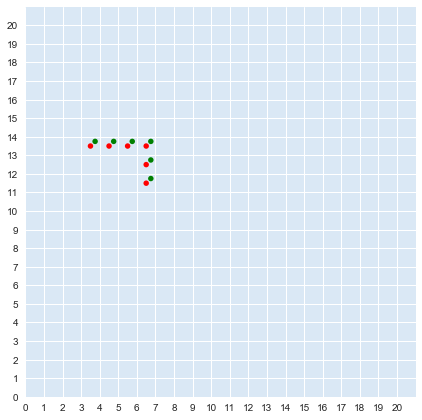

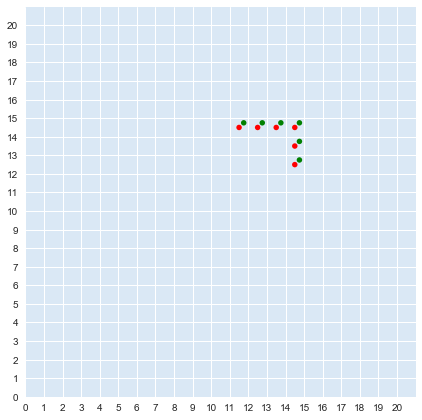

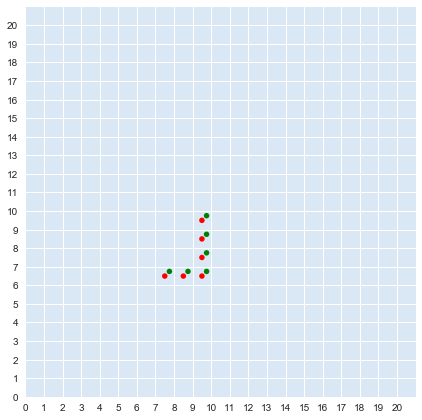

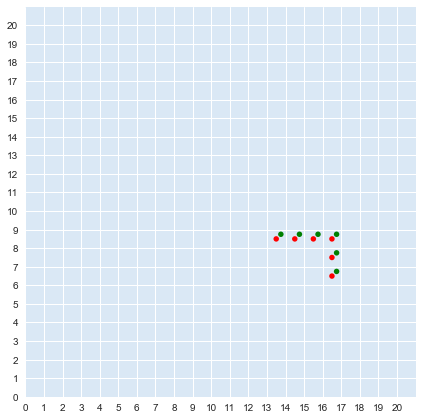

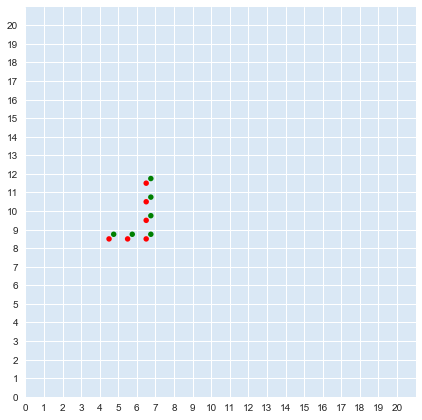

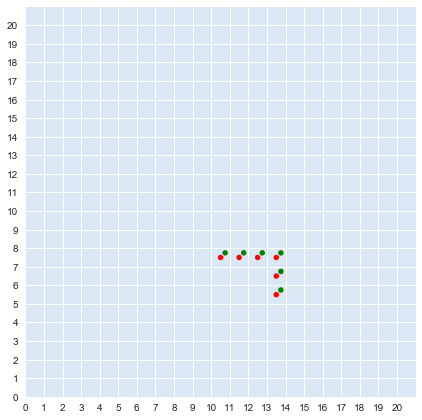

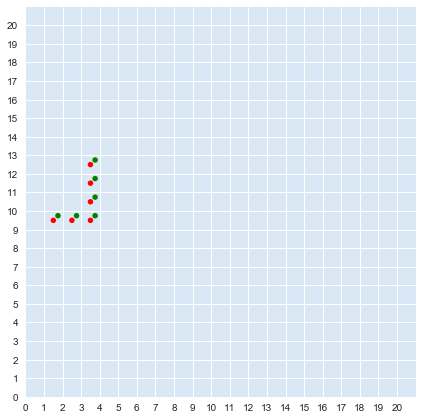

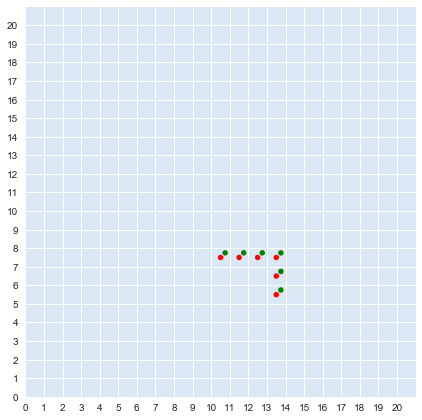

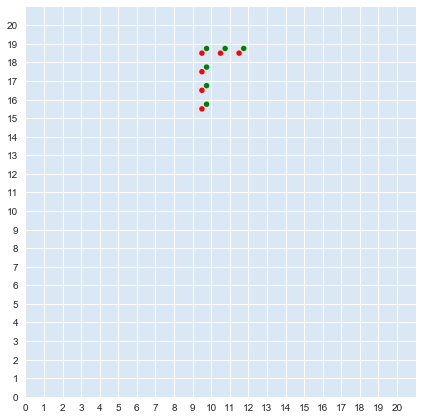

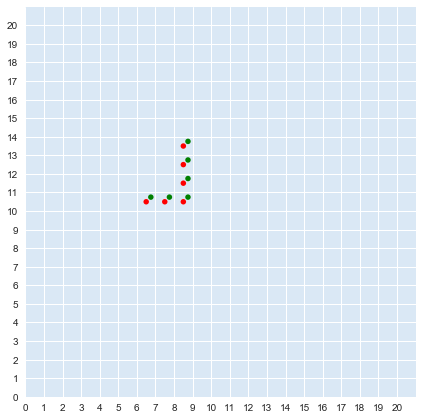

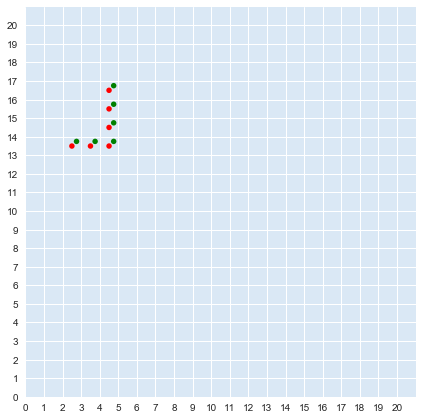

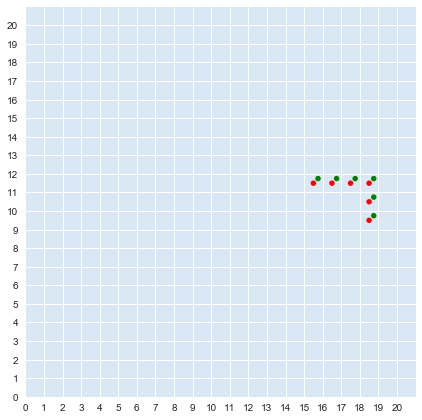

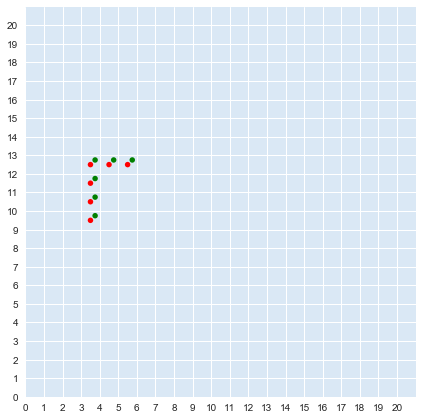

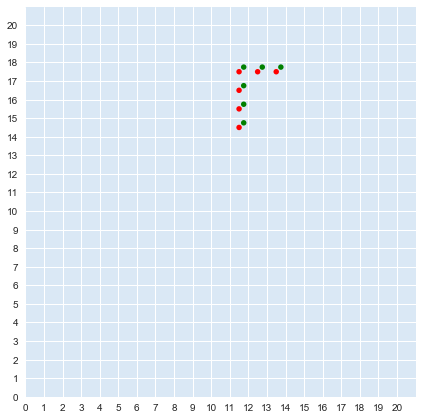

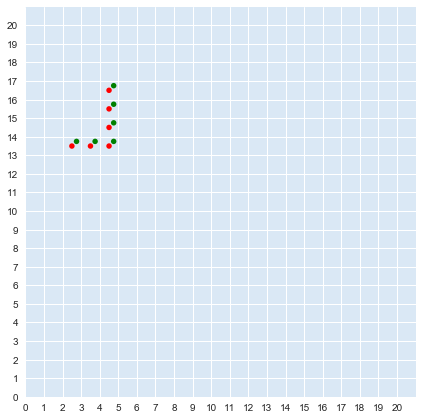

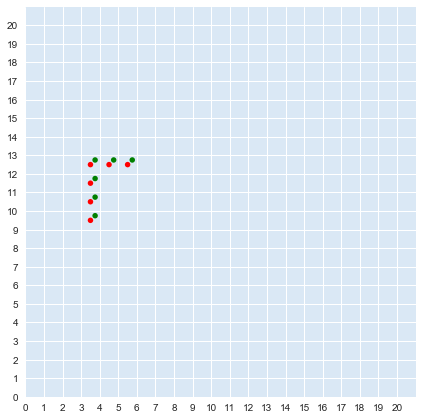

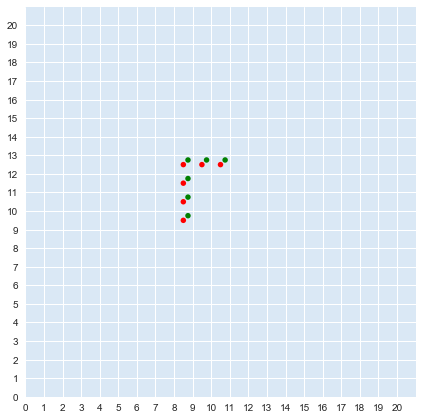

In [5]:
def plot_pickle_results(results_pkl_path, num_traj_to_plot=10):
    assert os.path.exists(results_pkl_path), \
        'results pickle does not exist {}'.format(results_pkl_path)
    with open(results_pkl_path, 'rb') as results_f:
        results_dict = pickle.load(results_f)
        print(type(results_dict))
        total_traj = len(results_dict['true_traj'])
        for i in range(num_traj_to_plot):
            traj_idx = np.random.randint(total_traj)
            traj_len = results_dict['true_traj'][traj_idx].shape[0]
            true_traj, pred_traj = [], []
            for j in range(traj_len):
                x_true = results_dict['true_traj'][traj_idx][j][0].tolist()
                x_pred = results_dict['pred_traj'][traj_idx][j][0].tolist()
                true_traj.append(x_true)
                pred_traj.append(x_pred)
            
            # Plot trajectory
            plot_trajectory(np.array(true_traj),
                            21,
                            pred_traj_data=np.array(pred_traj),
                            color_map=sns.color_palette("Blues_r"),
                            figsize=(6, 6))


plot_pickle_results('../results/L_traj/two_goal_predict_only/results.pkl',
                    num_traj_to_plot=50)